In [1]:
import numpy as np
import matplotlib.pyplot as plt

This notebook explores the background of the Kalman filter.

# Weighting the past against the present

The central idea of the Kalman filter is to weight the past against the present.
We're actually very familiar with this idea and ues it whenever averaging or low-pass filtering.

## Averaging

If we want to estimate some value $X$ but only have access to noisy measurements, the usual approach is to take $N$ noisy measurements and average them out to get an estimate of $X$. For 
 - $X$ the true value
 - $\tilde{X}_n$ a noisy measurement of $X$
 - $\hat{X}_N$ an estimate of $X$ given $N$ measurements

$$
\hat{X}_N = \frac{1}{N}\sum_{n=1}^N\tilde{X}_n
$$

Now, let's say that these measurements are arriving in time. We can express our current estimate in terms of our previous estimate

\begin{align}
\hat{X}_N &= \frac{1}{N}\sum_{n=1}^N\tilde{X}_n \\
    &= \frac{1}{N}(\tilde{X}_1+\tilde{X}_2+\ldots+\tilde{X}_{N-1}+\tilde{X}_N) \\
    &= \frac{N-1}{N}\frac{1}{N-1}(\tilde{X}_1+\tilde{X}_2+\ldots+\tilde{X}_{N-2}+\tilde{X}_{N-1}) + \frac{1}{N}\tilde{X}_N \\
    &= \frac{N-1}{N}\hat{X}_{N-1} + \frac{1}{N}\tilde{X}_N \\
\end{align}

We give our past estimate a weight of $\frac{N-1}{N}$ and our current measurement a weight of $\frac{1}{N}$.

We can also rewrite our current estimate as the sum of our previous estimate and the weighted difference between our current measurement and previous estimate.

$$
\hat{X}_N = \hat{X}_{N-1} + \frac{1}{N}(\tilde{X}_N-\hat{X}_{N-1}) \\
$$

Now the interpretation is that we are adjusting our previous estimate by the weighted difference between the measurement and previous estimate (i.e., what we might have expected to measure).

## Low Pass Filtering

We can see the same idea of weighting the a past estimate against a current measurement in a low-pass filter

$$\dot{\hat{X}}=\frac{1}{\tau}(-\hat{X}+\tilde{X})$$

By converting to discrete time using the Euler step*

\begin{align}
\hat{X}_T &= \hat{X}_{T-1} + \frac{\Delta t}{\tau}(-\hat{X}_{T-1} + \tilde{X}_{T-1}) \\
&= \left(1-\frac{\Delta t}{\tau}\right)\hat{X}_{T-1} + \frac{\Delta t}{\tau}\tilde{X}_{T-1}
\end{align}

We give our past estimate a weight of $\left(1-\frac{\Delta t}{\tau}\right)$ and our current measurement a weight of $\frac{\Delta t}{\tau}$. Note how this differs from the averaging case. Here the weights are constant, while with averaging, the weight changes with the number of samples. This difference follows from the different purposes of these processes---averaging is used when the underlying value doesn't change while low-pass filtering is used when the underlying value does.

As with averaging, we can rewrite our low-pass filter estimate in terms of our previous estimate and the diference between the current measurement and previous estimate.

$$\hat{X}_T = \hat{X}_{T-1} + \frac{\Delta t}{\tau}(\tilde{X}_{T-1}-\hat{X}_{T-1})$$

\* $\dot{X}\approx(X_T-X_{T-1})/\Delta t$ so $X_T\approx X_{T-1}+\Delta t\dot{X}$

# The Kalman Filter

The Kalman filter uses an underlying dynamical system model of

```
x[t] = Ax[t-1] + Bu[t-1] + w[t-1]
z[t] = Hx[t] + v[t]
```

where
 - $x$ is the state variable
 - $u$ is the input
 - $w$ is Gaussian process noise with covariance $Q$. There may be things outside of our control that influence the system.
 - $z$ is our measurement of $x$ and $H$ is the transformation between $x$ and $z$. $H$ may very well be identity.
 - $v$ is Gaussian measurement noise with covariance $R$. Our measurements themselves may be noisy, independent of the underlying process being measured.

Based on the dynamical system model, we want to build an estimate, $\hat{x}$, of $x$ using measurements $z$ and our model of the system. Our prediction will take the form

```
x_hat[t] = x_hat_predict[t]+K[t]y[t]
```

where `K` is the Kalman Gain and `y` is the difference between what we measured and what we predicted we would measure. The Kalman Gain dictates how much to weight to give our prediction vs what we observed.

For each time step, we use the previous time step's result to predict `x` at the current time step; we also estimate our prediction's error covariance, `P`.

```
x_hat_predict[t] = A x_hat[t-1] + B u[t-1]
P_hat_predict[t] = A P_hat[t-1] A.T + Q
```

Note how the current state prediction, `x_hat_predict[t]`, arises from simply ticking the system dynamics model forward one time step using the previous state estimation, `x_hat[t-1]`. We similarly tick the dynamics model forward to update the prediction covariance `P_hat_predict` but also account for process noise, `w`, by adding the process noise covariance `Q`.

Besides predicting the current state, we also predict the current measurement `z` and its covariance.

```
z_predict[t] = H x_hat_predict[t]
S_measure[t] = H P_hat[t] H.T + R
```

We then take a measurement and note the difference between what we measured and what we predicted

```
y[t] = z[t]-z_predict[t]
```

`y` is called the _innovation_.

We then decide how much to weight what we expected against the surprise by taking the ratio of the estimated process noise and the measurement noise.

```
S_process[t] = P_hat[t] H.T
K[t] = S_process S_measure[t]**-1
```

`K` is the Kalman gain, and we use it to update our estimate post measurement.

```
x_hat[t] = x_hat_predict[t]+K[t]y[t]
```

Note how this can be rewritten as weighting our current expectation against the current measurement.

```
x_hat[t] = (1-K[t])xhat_predict[t]+K[t]z[t]
```

We also use `K` to update our estimate of the error covariance

```
P_hat[t] = (I-K[t])P_hat_predict[t]
```

This completes the step, and from here, the Kalman filter repeats.

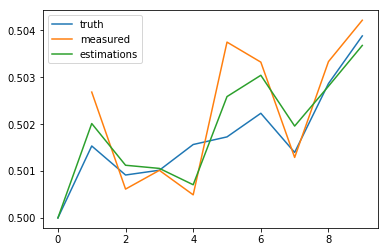

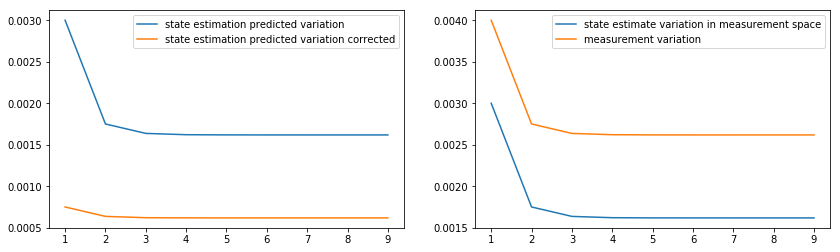

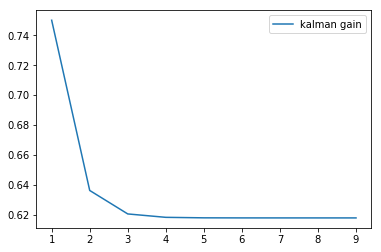

In [16]:
A = 1
B = 0
H = 1

Q = 0.001 # process noise
R = 0.001 # measurement noise
p_hat_0 = 2*Q
x_0 = 0.5
x_hat_0 = 0.5
T = 10

x = np.zeros(T) # state
x[0] = x_0
u = np.zeros_like(x)
w = np.random.normal(scale=Q, size=x.shape[0]) # process noise
# w = np.zeros_like(x) # process noise

x_hat_predict = np.zeros_like(x) # predicted state estimate
x_hat = np.zeros_like(x) # state estimate
x_hat_predict[0] = x_hat_0
x_hat[0] = x_hat_0

p_hat_predict = np.zeros_like(x) # state estimate covariance 
p_hat = np.zeros_like(x) # state estimate covariance 
p_hat_predict[0] = p_hat_0
p_hat[0] = p_hat_0

z_predict = np.zeros_like(x) # predicted measurement
z = np.zeros_like(x) # measurement
s_process = np.zeros_like(x) # predicted state estimate covariance projected into measurement space
s_measure = np.zeros_like(x) # predicted measurement covariance
v = np.random.normal(scale=R, size=x.shape[0]) # measurement noise

K = np.zeros_like(x) # kalman gain

for t in range(T)[1:]:
    # step the underlying process
    x[t] = A*x[t-1]+B*u[t-1]+w[t-1]

    # make predictions of the current state and its covariance
    x_hat_predict[t] = A*x_hat[t-1] + B*u[t-1]
    p_hat_predict[t] = A*p_hat[t-1]*A + Q
    # make predictions of the current measurement and its covariance
    z_predict[t] = H * x_hat_predict[t]
    s_measure[t] = H * p_hat_predict[t] * H + R
    
    # calculate the kalman gain
    s_process[t] = p_hat_predict[t] * H # project state estimation into measurement space
    K[t] = s_process[t]*s_measure[t]**-1
    
    # take a measurement
    z[t] = H*x[t]+v[t]
    # calculate the innovation
    y = z[t] - z_predict[t]
    
    # update state and covariance estimates with weighted innovation
    x_hat[t] = x_hat_predict[t] + K[t]*y
    p_hat[t] = (1-K[t]*H)*p_hat_predict[t]

T_plot = range(T)[1:]

plt.figure()
plt.plot(x, label="truth")
plt.plot(T_plot, z[1:], label="measured")
plt.plot(x_hat, label="estimations")
plt.legend(loc="best")

fig, axs = plt.subplots(ncols=2, figsize=(14,4))
axs[0].plot(T_plot, p_hat_predict[1:], label="state estimation predicted variation")
axs[0].plot(T_plot, p_hat[1:], label="state estimation predicted variation corrected")
axs[0].legend(loc="best")
axs[1].plot(T_plot, s_process[1:], label="state estimate variation in measurement space")
axs[1].plot(T_plot, s_measure[1:], label="measurement variation")
axs[1].legend(loc="best")

plt.figure()
plt.plot(T_plot, K[1:], label="kalman gain")
plt.legend(loc="best")

plt.show()

# Limitations and Usage

The Kalman filter assumes the system dynamics and noise characteristics. If these assumptions do not match reality, then the KF will have a systematic bias.

Is there a way to learn the dynamics and noise model to fit the KF?

# Continuous Time

To convert discrete to continuous time, recall Euler's Method. 

\begin{align}
\frac{dx}{dt} &= \frac{x_{t}-x_{t-1}}{\Delta t} \\
x_{t} &= x_{t-1} + \Delta t\frac{dx}{dt}
\end{align}

So given the discrete and continuous time equations

\begin{align}
x_{t} &= A^{DT}x_{t-1} + B^{DT}u_{t-1} \\
\frac{dx}{dt} &= A^{CT}x + B^{CT}u
\end{align}

If we plug Euler's Method in to the discrete equation,

\begin{align}
x_{t-1} + \Delta t\frac{dx}{dt} &= A^{DT}x_{t-1} + B^{DT}u_{t-1} \\
\frac{dx}{dt} &= \frac{1}{\Delta t}(A^{DT}-I)x_{t-1} + \frac{1}{\Delta t}B^{DT}u_{t-1}
\end{align}

Therefore to convert discrete time matrices to continuous time, use

\begin{align}
A^{CT} &= \frac{1}{\Delta t}(A^{DT}-I) \\
B^{CT} &= \frac{1}{\Delta t}B^{DT}
\end{align}

so that the continuous form of the Kalman filter will be

\begin{align}
\dot{x} &= \frac{1}{\Delta t}(A-I)x+\frac{1}{\Delta t}Bu + w \\
z &= Hx + v
\end{align}

# Helpful Links

- http://robotsforroboticists.com/kalman-filtering/
- http://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf